In [1]:
import glob

import mne
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
from scipy import signal
from scipy.fftpack import fft, fftfreq, ifft, irfft, rfft
from scipy.integrate import simps
from scipy.signal import butter, filtfilt, hilbert

In [2]:
# read the excel files just in case 
patients_256 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_256Hz.xlsx")
patients_250 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_250Hz.xlsx")

/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
patients_250 = patients_250.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_250 = patients_250.dropna(subset = ["ID"])
patients_250 = patients_250.astype({"ID" : int})
patients_250_ids = list(patients_250["ID"])

In [4]:
patients_256 = patients_256.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_256 = patients_256.dropna(subset = ["ID"])
patients_256 = patients_256.astype({"ID" : int})
patients_256_ids = list(patients_256["ID"])
#patients_df = pd.concat([patients_data, patients_data1])
#patients_df = patients_df.drop(["file code"], axis = 1)

In [5]:
#not_annoted = patients_df[patients_df["BS"].isna()]
#annotated_patients = patients_df[patients_df['BS'].notna()]

In [5]:
patients = glob.glob("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /*.mat")
patient_files_250 = []
patient_files_256 = []

for i in range(0,len(patients)): 
    temp = patients[i].replace("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /patient_","")
    temp = int(temp.replace(".mat", ""))
    if temp in patients_250_ids:
        patient_files_250.append(patients[i])
    else:
        patient_files_256.append(patients[i])
    

In [6]:
# necessary information taken from the data in order to create MNE objects. 
channelLabels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6', '01', '02', 'ECG']
trials = 1 
n_channels = 22
ch_types = ['eeg'] * (n_channels-3)
ch_types.append('misc')
ch_types.append('misc')
ch_types.append('ecg')

In [7]:
def define_montage(type):
    '''method that helps us define the channel locations '''

    # Form the 10-20 montage 'standard_1020'
    mont1020 = mne.channels.make_standard_montage(type)
    # Choose what channels you want to keep 
    # Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
    kept_channels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6']
    ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
    mont1020_new = mont1020.copy()
    # Keep only the desired channels
    mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
    kept_channel_info = [mont1020.dig[x+3] for x in ind]
    # Keep the first three rows as they are the fiducial points information
    mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
    
    #mont1020.plot()
    #mont1020_new.plot()
    
    return mont1020_new

In [8]:
def create_MNE_objects(patient_list,channelLabels,n_channels,sampling_frequency,phase,types): 
    evoked_arrays = []
    for i in range(0,len(patient_list)): 
        patient = scipy.io.loadmat(patient_list[i])
        samples = patient[phase]["data"][0][0]
        
        info = mne.create_info(
        ch_names = channelLabels, 
        ch_types = types,
        sfreq = sampling_frequency)
        
        info.set_montage(define_montage('standard_1020'))
        evoked_array = mne.EvokedArray(samples, info,
                               nave=samples.shape[0], comment=('patient' + str(i)))
        evoked_arrays.append(evoked_array)
    return evoked_arrays

In [9]:
def create_Raw_objects(patient_list,channelLabels,n_channels,sampling_frequency,phase,types,ids):
    evoked_arrays = {}
    for i in range(0,len(patient_list)): 
        patient = scipy.io.loadmat(patient_list[i])
        samples = patient[phase]["data"][0][0]
        
        info = mne.create_info(
        ch_names = channelLabels, 
        ch_types = types,
        sfreq = sampling_frequency)
        
        info.set_montage(define_montage('standard_1020'))
        evoked_array = mne.io.RawArray(samples, info)
        evoked_arrays.update({ids[i] : evoked_array })
    return evoked_arrays

In [10]:
eeg_InDia_250 = create_Raw_objects(patient_files_250, channelLabels, n_channels, 250,"EEG_INDIA",ch_types,patients_250_ids)
eeg_InDia_256 = create_Raw_objects(patient_files_256,channelLabels, n_channels, 256, "EEG_INDIA", ch_types,patients_256_ids)
#eeg_PreOK = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_PreOK",ch_types)
#eeg_Klem = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_Klem",ch_types)

Creating RawArray with float64 data, n_channels=22, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.004 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=391128
    Range : 0 ... 391127 =      0.000 ...  1564.508 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=169409
    Range : 0 ... 169408 =      0.000 ...   677.632 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=291251
    Range : 0 ... 291250 =      0.000 ...  1165.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=162501
    Range : 0 ... 162500 =      0.000 ...   650.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=152051
    Range : 0 ... 152050 =      0.000 ...   608.200 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=369993
    Range : 0 ... 369992 =      0.000 ...  1479.968 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=501
    Range : 0 ... 500 =     

In [11]:
#remove the signal data where the n_times == 0 
def remove_zero_times(raw_array,patient_ids) : 
    res = raw_array.copy() 
    for i in raw_array: 
        if raw_array[i].n_times == 0 or raw_array[i].n_times == 1:
            del res[i]
            patient_ids.remove(i)
    
    return res,patient_ids

In [12]:
eeg_india_250, patients_250_ids= remove_zero_times(eeg_InDia_250,patients_250_ids)
eeg_india_256, patients_256_ids = remove_zero_times(eeg_InDia_256,patients_256_ids)


In [13]:
eeg_india = {}
eeg_india.update(eeg_india_250)
eeg_india.update(eeg_india_256)


## Time Domain Features 

In [14]:
## extract time-domain features 

def calculate_mean(raw_array, patient_ids):
    mean_dict = {}
    for i in patient_ids: 

        col_mean = raw_array[i].get_data().mean(axis = 1)
        mean = col_mean.mean()

        mean_dict.update({i : mean})
    return mean_dict


def standard_deviation(raw_array, patient_ids): 
    std_dict = {}
    for i in patient_ids: 

        col_std = raw_array[i].get_data().std(axis = 1)
        std = col_std.std()

        std_dict.update({i : std})
    return std_dict





## Frequency Domain Transformation and Features

In [15]:

def calculate_psd(raw_array,fmin, fmax) : 
    psd_arr = []
    freq_arr = []
    for  i in raw_array: 
        print(i)
        spectrum = raw_array[i].compute_psd(method= "welch", fmin = fmin, fmax = fmax)
        psd,freq = spectrum.get_data(return_freqs = True)
    return psd,freq


 -  delta (0.5–4 Hz)
  - theta (4–8 Hz)  
 -  alpha (8–12 Hz)
 -  beta (12–30 Hz)
 -  gamma (30–100 Hz)

In [16]:
# ## find the different power bands 
# psd_delta,freq_delta = calculate_psd(eeg_india, 0.5, 3)
# psd_theta, freq_theta = calculate_psd(eeg_india,4,7)
# psd_alpha,freq_alpha = calculate_psd(eeg_india, 8,11)
# psd_beta,freq_beta = calculate_psd(eeg_india,12,29)
# psd_gamma, freq_gamma = calculate_psd(eeg_india,30,100)


In [27]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.
        Absolute or relative band power.
    """
    from scipy.integrate import simps
    from scipy.signal import welch
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

def average_band_power(band, eeg_array,relative = False):
    mean_bps = []
    for i in eeg_array: 
        bps = []
        for j in range(0,22): 
            bp = bandpower(eeg_array[i].get_data()[j],250,band,window_sec=4,relative = relative)
            bps.append(bp) 
        mean  = np.mean(bps)
        mean_bps.append(mean)
    return mean_bps

In [28]:
mean_power_delta = average_band_power([0.5,3],eeg_india)
mean_power_theta = average_band_power([4,7],eeg_india)
mean_power_alpha = average_band_power([8,11],eeg_india)
mean_power_beta = average_band_power([12,29],eeg_india)
mean_power_gamma = average_band_power([30,50],eeg_india)

/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 1000 is greater than input length  = 501, using nperseg = 501
  warnings.warn('nperseg = {0:d} is greater than input length '


In [29]:
mean_rel_power_delta = average_band_power([0.5,3],eeg_india,relative = True)
mean_rel_power_theta = average_band_power([4,7],eeg_india,relative = True)
mean_rel_power_alpha = average_band_power([8,11],eeg_india,relative = True)
mean_rel_power_beta = average_band_power([12,29],eeg_india,relative = True)
mean_rel_power_gamma = average_band_power([30,50],eeg_india,relative = True)

In [30]:
ids = patients_250_ids+ patients_256_ids
power_df = pd.DataFrame({"ID" : ids, 
                        "mean_alpha" : mean_power_alpha,
                        "mean_beta" : mean_power_beta, 
                        "mean_delta" : mean_power_delta, 
                        "mean_theta" : mean_power_theta, 
                        "mean_gamma" : mean_power_gamma,
                        "mean_rel_alpha" : mean_rel_power_alpha, 
                        "mean_rel_power_beta" : mean_rel_power_beta, 
                        "mean_rel_delta" : mean_rel_power_delta, 
                        "mean_rel_theta" : mean_rel_power_theta, 
                        "mean_rel_gamma" : mean_rel_power_gamma})
power_df



,ID,mean_alpha,mean_beta,mean_delta,mean_theta,mean_gamma,mean_rel_alpha,mean_rel_power_beta,mean_rel_delta,mean_rel_theta,mean_rel_gamma
0,2,764.920630,1349.943873,14320.790485,1777.312221,357.657911,0.024887,0.040890,0.558663,0.063715,0.009409
1,3,86.456281,124.713149,296.249773,96.255024,7.701605,0.097956,0.075851,0.406157,0.055648,0.003815
2,4,154.636817,226.032110,3346.703460,421.188436,17.621548,0.039922,0.018549,0.496653,0.046241,0.000685
3,5,143.427287,159.414865,694.557521,388.866932,10.476489,0.044997,0.056448,0.494827,0.091941,0.003556
4,6,931.062647,1071.675749,7690.848703,2557.032800,208.667589,0.059229,0.039847,0.527359,0.050315,0.001730
...,...,...,...,...,...,...,...,...,...,...,...
243,373,181.254053,287.093845,1447.762313,357.239940,26.236140,0.016826,0.021156,0.442978,0.055377,0.001760
244,375,69.439583,222.848124,615.246168,94.275305,24.468055,0.014103,0.048847,0.445063,0.022707,0.003357
245,376,21201.870771,95782.721831,13421.655833,24330.664169,67903.824577,0.093367,0.413385,0.059660,0.107408,0.283963
246,377,64.810302,75.726665,354.807163,168.467832,4.090750,0.151605,0.104915,0.331459,0.043574,0.017102


In [31]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):

    import matplotlib.pyplot as plt
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import periodogram, welch
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax2.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax1.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax2.plot(freqs, psd, lw=lw, color=lc)
    ax1.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax2.set_title('Periodogram')
    ax1.set_title('Mean-power Alpha Band')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


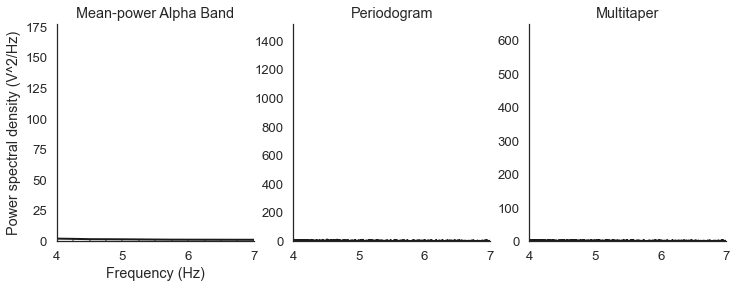

In [32]:
plot_spectrum_methods(eeg_india[16].get_data()[2], 250, 4, band=[4,7], dB=False)

In [33]:
def calc_shannon_entropy(data_set):
    probability = np.square(data_set)
    shannon_entropy = -np.nansum(probability * np.log2(probability))
    return round(shannon_entropy, 3)

NOTE: plot_psd_topo() is a legacy function. New code should use .compute_psd().plot_topo().
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


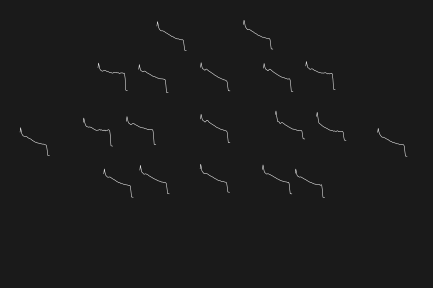

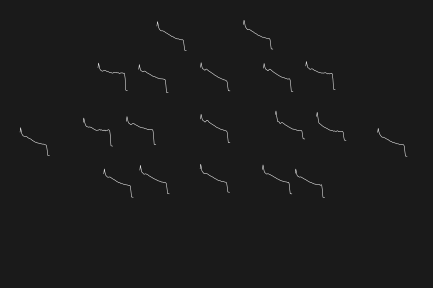

In [34]:
eeg_india[16].plot_psd_topo(fmax = 50)


Effective window size : 1.024 (s)


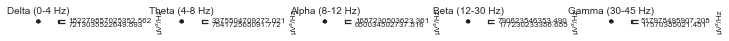

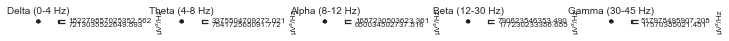

In [35]:
eeg_india[16].compute_psd().plot_topomap()

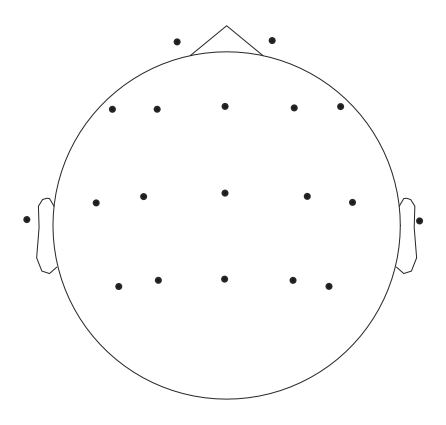

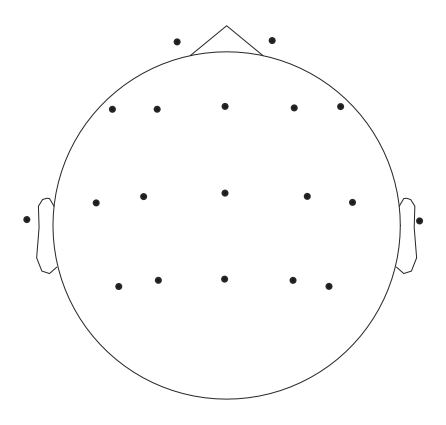

In [36]:
eeg_india[16].plot_sensors(ch_type = "eeg")

In [37]:
patients_df = patients_250.append(patients_256,ignore_index=True)
patients_df = patients_df[patients_df["ID"].isin(ids)]
patients_df = pd.merge(patients_df,power_df, on = "ID")
patients_df.drop(["Tijdstip ogen dicht", "Tijdstip ogen open", "tijdstip tweede ogen dicht", "tijdstip tweede ogen open", 
                   "tijdstip derde ogen dicht","tijdstip derde ogen open", "Tijdstip start op OK","Tijdstip start inleiding",'Tijdstip start diathermie', 'Tijdstip start klem', 'Duur klem',
       'Tijdstip einde OK', 'file code','opm'], inplace=True, axis=1)
patients_df["BS"] = patients_df["BS"].map({'ja' : 1, 'nee' : 0})

annotated_df  = patients_df[patients_df["BS"].notna()]
not_annotated_df = patients_df[patients_df["BS"].isna()]
annotated_df

/var/folders/v7/vrxjycqx6736th34cms70szm0000gn/T/ipykernel_1065/1836507250.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_250.append(patients_256,ignore_index=True)


,ID,BS,Age at OR,mean_alpha,mean_beta,mean_delta,mean_theta,mean_gamma,mean_rel_alpha,mean_rel_power_beta,mean_rel_delta,mean_rel_theta,mean_rel_gamma
7,9,1.0,76.889802,141.606081,58.923562,11192.278058,863.937302,8.834841,0.076175,0.049133,0.267528,0.020639,0.025385
14,19,0.0,74.047912,11.124319,11.866992,81.450714,8.889858,0.407683,0.033929,0.014757,0.282286,0.026896,0.000531
20,25,0.0,59.838467,519.118294,1005.209656,8728.196627,1457.917162,218.175927,0.031206,0.062461,0.540993,0.087827,0.015136
24,30,1.0,57.924709,245.267338,290.287486,4722.684795,586.112748,32.972606,0.022873,0.028106,0.537621,0.064250,0.004859
29,39,0.0,88.131417,246.126106,187.295694,1897.827458,622.990105,45.237789,0.038175,0.054449,0.467921,0.077484,0.014810
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,373,0.0,79.362081,181.254053,287.093845,1447.762313,357.239940,26.236140,0.016826,0.021156,0.442978,0.055377,0.001760
244,375,1.0,69.804244,69.439583,222.848124,615.246168,94.275305,24.468055,0.014103,0.048847,0.445063,0.022707,0.003357
245,376,0.0,75.707050,21201.870771,95782.721831,13421.655833,24330.664169,67903.824577,0.093367,0.413385,0.059660,0.107408,0.283963
246,377,1.0,69.253936,64.810302,75.726665,354.807163,168.467832,4.090750,0.151605,0.104915,0.331459,0.043574,0.017102


In [38]:
annotated_df.isnull().sum()
print(annotated_df.columns)

Index(['ID', 'BS', 'Age at OR', 'mean_alpha', 'mean_beta', 'mean_delta',
       'mean_theta', 'mean_gamma', 'mean_rel_alpha', 'mean_rel_power_beta',
       'mean_rel_delta', 'mean_rel_theta', 'mean_rel_gamma'],
      dtype='object')


## Classification 

In [106]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier

In [94]:
feature_cols = ['Age at OR', 'mean_alpha', 'mean_beta', 'mean_delta',
        'mean_gamma', 'mean_rel_alpha', 'mean_rel_power_beta',
       'mean_rel_delta', 'mean_rel_gamma']
X = annotated_df[feature_cols]
y = annotated_df.BS


In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 70% training and 30% test
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [96]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5925925925925926


[Text(125.55000000000001, 190.26, 'X[2] <= 10.972\nentropy = 0.796\nsamples = 108\nvalue = [82, 26]'),
 Text(83.7, 135.9, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(167.4, 135.9, 'X[4] <= 4.006\nentropy = 0.758\nsamples = 105\nvalue = [82, 23]'),
 Text(83.7, 81.53999999999999, 'X[5] <= 0.03\nentropy = 0.31\nsamples = 18\nvalue = [17, 1]'),
 Text(41.85, 27.180000000000007, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(125.55000000000001, 27.180000000000007, 'entropy = 0.0\nsamples = 16\nvalue = [16, 0]'),
 Text(251.10000000000002, 81.53999999999999, 'X[3] <= 125.085\nentropy = 0.816\nsamples = 87\nvalue = [65, 22]'),
 Text(209.25, 27.180000000000007, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(292.95, 27.180000000000007, 'entropy = 0.771\nsamples = 84\nvalue = [65, 19]')]

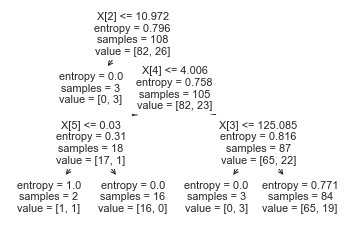

In [97]:
tree.plot_tree(clf)

In [98]:
scoring = 'neg_log_loss'
kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
results = model_selection.cross_val_score(clf, X, y, cv=kfold, scoring=scoring)
print("Log-loss : ", results.mean(), results.std() )

Log-loss :  -2.068102273740627 1.2597162201914036


In [103]:
auc = model_selection.cross_val_score(clf, X, y, cv=kfold, scoring='roc_auc')
print("AUC: %.3f (%.3f)" % (auc.mean(), auc.std()))
matrix = confusion_matrix(y_test, y_pred)
print("confusion_matrix", matrix)


AUC: 0.472 (0.096)
confusion_matrix [[15  1]
 [10  1]]


In [104]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.60      0.94      0.73        16
         1.0       0.50      0.09      0.15        11

    accuracy                           0.59        27
   macro avg       0.55      0.51      0.44        27
weighted avg       0.56      0.59      0.50        27



### Random Forest Classifier 

In [149]:
cols = ['Age at OR', 'mean_alpha','mean_beta', 'mean_delta',
        'mean_gamma', 'mean_rel_alpha', 'mean_rel_power_beta',
       'mean_rel_delta', 'mean_rel_gamma']
feature_cols = ['mean_alpha','mean_theta','mean_beta', 'mean_delta',
        'mean_gamma','mean_rel_alpha']
X = annotated_df[feature_cols]
y = annotated_df.BS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34)
print(X.shape)
print(y.shape)

(135, 6)
(135,)


### Random Forest Classifier 

In [150]:

random_forest_clf = RandomForestClassifier(max_depth = 2, n_estimators=100)
random_forest_clf.fit(X_train, y_train)
y_pred = random_forest_clf.predict(X_test)


In [151]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.717391304347826


No handles with labels found to put in legend.


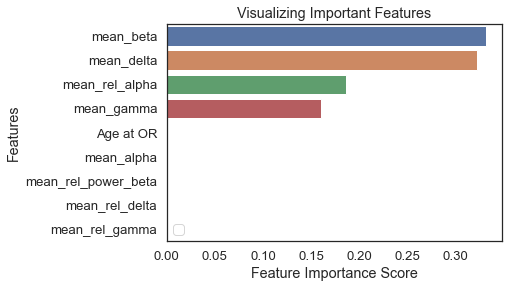

In [152]:
feature_imp = pd.Series(clf.feature_importances_,index=cols ).sort_values(ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()